# Functional annotation plots (CAZy / COG / AMR)

This notebook generates summary plots for functional annotation results (CAZy, COG, and AMR) at the **sample** level and as **food-category** summaries.

Most plots are produced twice:
- **Per-sample**: keeps within-category variability (useful for QC and spotting outliers).
- **By category**: aggregates samples that share the same `category` label (cleaner for reporting).

Outputs:
- Figures: `data/07_Functional_analysis/data/Plots/`
- Cached QIIME2 exports: `exported/` (reused when `DO_EXPORT = False`)


## Prepare environment

#### Import packages

In [1]:
from __future__ import annotations

from pathlib import Path
import re
import math
import subprocess
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

%matplotlib inline


#### Paths and parameters

Set `DATA_DIR` to the folder that contains the QIIME2 artifacts for this section.
Figures will be written to `DATA_DIR/Plots/`.


In [2]:
# Project layout (edit if needed)
DATA_DIR = Path("data/07_Functional_analysis/data")
META_TSV = Path("data/merged_metadata_filtered.tsv")

# QIIME2 artifacts produced upstream
MAGS_TABLE_QZA = DATA_DIR / "mags_table_bacteria_95.qza"
CAZY_FT_QZA    = DATA_DIR / "caz_annot_ft_bacteria_95.qza"
COG_FT_QZA     = DATA_DIR / "cog_annot_ft_bacteria_95.qza"
AMR_FT_QZA     = DATA_DIR / "amr_ft_bacteria_95.qza"

# Output folders
FIG_DIR = DATA_DIR / "Plots"  # save figures alongside upstream artifacts
FIG_DIR.mkdir(parents=True, exist_ok=True)
EXP_DIR = Path("exported"); EXP_DIR.mkdir(parents=True, exist_ok=True)

# Plot parameters
TOP_N_SAMPLES = 25
TOP_N_FAMILIES = 30
TOP_N_SAMPLES_FAMS = 25
RANDOM_SEED = 0

# Export behaviour:
# If TSVs already exist under exported/*, set DO_EXPORT=False for faster reruns.
DO_EXPORT = False
# Known eukaryotic MAG member IDs to exclude (UUIDs)
EXCLUDE_MEMBER_UUIDS_RAW = [
    "09ebb84d-e6d1-4c36-871b-45bee0ad115d",
    "b016ed44-d4d7-4927-b6fc-b8eb341adbf7",
]



## Helper functions

#### I/O

In [3]:
UUID_RE = re.compile(
    r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}",
    flags=re.I,
)
CAZY_FAM_RE = re.compile(r"(GH|GT|CE|PL|AA|CBM)\d+", flags=re.I)


def run(cmd: List[str]) -> None:
    """Run a shell command and raise if it fails."""
    res = subprocess.run(cmd, capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError(
            "Command failed:\n" + " ".join(cmd)
            + "\n\nSTDOUT:\n" + res.stdout
            + "\n\nSTDERR:\n" + res.stderr
        )


def export_qza_to_tsv(qza: Path, export_dir: Path, tsv_out: Path, *, force: bool = False) -> None:
    """Export a FeatureTable QZA and convert it to a TSV (biom -> tsv)."""
    if tsv_out.exists() and not force:
        return

    export_dir.mkdir(parents=True, exist_ok=True)
    run(["qiime", "tools", "export", "--input-path", str(qza), "--output-path", str(export_dir)])

    biom_fp = export_dir / "feature-table.biom"
    if not biom_fp.exists():
        raise FileNotFoundError(f"Expected biom file not found after export: {biom_fp}")

    run([
        "biom", "convert",
        "-i", str(biom_fp),
        "-o", str(tsv_out),
        "--to-tsv",
    ])


def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    """Read biom-convert TSV where first row is a comment and second row is header."""
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    first_col = df.columns[0]  # '#OTU ID' or similar
    df = df.set_index(first_col)
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return df


#### Mapping (member UUID → sample_ID)

Some feature tables are keyed by dereplication member IDs (UUIDs) rather than sample IDs.
We use the dereplication membership table (`mags_table_*.qza`) to map member IDs back to sample IDs and then merge columns that belong to the same sample.

Known eukaryotic members can be excluded here so they do not contribute to any of the summaries.


In [4]:
def canon_id(x: str) -> str:
    """Normalise an ID for lookups (UUID -> lowercase UUID; otherwise lowercase string)."""
    s = str(x).strip()
    m = UUID_RE.search(s)
    return m.group(0).lower() if m else s.lower()


def build_sample_id_matcher(sample_ids: List[str]) -> Tuple[re.Pattern, Dict[str, str]]:
    """Build a regex that can recover sample_ID from rep IDs like pb_m010 / il_ms003-2."""
    sid_lower_to_orig = {str(s).strip().lower(): str(s).strip() for s in sample_ids}
    # Longest-first avoids matching MS001 inside MS001-3
    alts = sorted(sid_lower_to_orig.keys(), key=len, reverse=True)
    pat = re.compile("|".join(re.escape(a) for a in alts))
    return pat, sid_lower_to_orig


def rep_to_sample(rep_id: str, *, sid_pat: re.Pattern, sid_lut: Dict[str, str]) -> Optional[str]:
    """Recover sample_ID from a representative ID (best-effort)."""
    r = str(rep_id).strip().lower()
    r = re.sub(r"^(il|pb)_", "", r)  # drop tech prefix if present
    m = sid_pat.search(r)
    return sid_lut[m.group(0)] if m else None


def _pick_feature_table_tsv(export_dir: Path, preferred_stem: str) -> Optional[Path]:
    """Choose a TSV that looks like a BIOM-converted feature table."""
    if not export_dir.exists():
        return None
    tsvs = list(export_dir.glob("*.tsv"))
    if not tsvs:
        return None

    # Prefer canonical filename if present
    for name in ["feature-table.tsv", f"{preferred_stem}.tsv", f"{preferred_stem}_feature-table.tsv"]:
        p = export_dir / name
        if p.exists():
            return p

    # Otherwise, take the largest TSV (usually the table; avoids tiny mapping reports)
    tsvs = sorted(tsvs, key=lambda p: p.stat().st_size, reverse=True)
    return tsvs[0]


def load_member_to_rep(mags_qza: Path, *, sample_ids: List[str]) -> Dict[str, str]:
    """Load derep membership table and return mapping: member_uuid -> rep_id."""
    # Reuse old exports when available: exported/<qza_stem>/
    export_dir = EXP_DIR / mags_qza.stem

    existing_tsv = _pick_feature_table_tsv(export_dir, mags_qza.stem)
    if existing_tsv is None or DO_EXPORT:
        tsv_out = export_dir / "feature-table.tsv"
        export_qza_to_tsv(mags_qza, export_dir, tsv_out, force=True)
        tsv_path = tsv_out
    else:
        tsv_path = existing_tsv

    tab = read_biom_tsv(tsv_path)

    # Normalise IDs for robust matching
    tab.index = [canon_id(i) for i in tab.index]
    tab.columns = [canon_id(c) for c in tab.columns]

    # Collapse any duplicated IDs
    tab = tab.groupby(level=0).sum()
    tab = tab.T.groupby(level=0).sum().T

    # The membership table is usually one-hot (each member belongs to one rep).
    # If it is transposed in export, flip it back.
    row_sum = tab.sum(axis=1)
    rows_are_members = (row_sum.replace(0, np.nan).median() <= 1.5)
    if not rows_are_members:
        tab = tab.T

    member_to_rep = tab.idxmax(axis=1).to_dict()
    # Drop known eukaryotic members (if provided)
    _exclude_raw = globals().get("EXCLUDE_MEMBER_UUIDS_RAW", [])
    _exclude = {canon_id(x) for x in _exclude_raw}
    if _exclude:
        before_n = len(member_to_rep)
        member_to_rep = {k: v for k, v in member_to_rep.items()
                         if (canon_id(k) not in _exclude) and (canon_id(v) not in _exclude)}
        dropped = before_n - len(member_to_rep)
        if dropped:
            print(f"Excluded {dropped} eukaryotic member IDs from mags_table mapping.")
    print(f"Loaded mags_table mapping: {len(member_to_rep)} members → {len(set(member_to_rep.values()))} reps")
    return member_to_rep


In [5]:
# Exclude known eukaryotic MAG members (if any)
_exclude_raw = globals().get('EXCLUDE_MEMBER_UUIDS_RAW', [])
_exclude = {canon_id(x) for x in _exclude_raw}
if _exclude:
    print('Excluding eukaryotic member UUIDs:', ', '.join(sorted(_exclude)))


Excluding eukaryotic member UUIDs: 09ebb84d-e6d1-4c36-871b-45bee0ad115d, b016ed44-d4d7-4927-b6fc-b8eb341adbf7


In [6]:
def map_columns_to_samples(df: pd.DataFrame, *, sample2cat: Dict[str, str], report_name: str) -> pd.DataFrame:
    """Map table columns to metadata sample_IDs and aggregate columns per sample."""
    sample_ids = list(sample2cat.keys())
    sid_pat, sid_lut = build_sample_id_matcher(sample_ids)

    # Optional: exclude known eukaryotic member IDs (UUIDs)
    _exclude_raw = globals().get("EXCLUDE_MEMBER_UUIDS_RAW", [])
    _exclude = {canon_id(x) for x in _exclude_raw}


    # Build member UUID → rep mapping (for MAG-level columns)
    try:
        member_to_rep = load_member_to_rep(MAGS_TABLE_QZA, sample_ids=sample_ids)
    except Exception as e:
        print(f"⚠️ Could not load mags table mapping: {e}")
        member_to_rep = {}

    mapped = {}
    unmapped = []

    for col in df.columns.astype(str):
        if _exclude and canon_id(col) in _exclude:
            continue
        c = col.strip()

        # 1) already a sample_ID
        if c in sample2cat:
            mapped[col] = c
            continue

        # 2) try member UUID → rep → sample_ID
        rep = member_to_rep.get(canon_id(c), c)
        s = rep_to_sample(rep, sid_pat=sid_pat, sid_lut=sid_lut)

        if s is None:
            unmapped.append(c)
            continue

        mapped[col] = s

    # Keep only mapped columns
    keep_cols = [c for c in df.columns if c in mapped]
    before = df.shape[1]
    df2 = df.loc[:, keep_cols].copy()
    df2.columns = [mapped[c] for c in keep_cols]

    # Aggregate multiple columns that map to the same sample_ID
    df2 = df2.groupby(level=0, axis=1).sum()
    after = df2.shape[1]
    print(f"Sample columns ({report_name}): {before} → {after} after mapping/aggregation.")

    # Save a small report for debugging
    rep_fp = EXP_DIR / f"{report_name}_column_mapping.tsv"
    pd.DataFrame({"original_id": list(mapped.keys()), "sample_ID": list(mapped.values())}).to_csv(rep_fp, sep="\t", index=False)

    if unmapped:
        u = sorted(set(unmapped))
        print(f"⚠️ {len(u)} column IDs could not be mapped to metadata sample_IDs.")
        print("  Examples:", u[:10])

    return df2


In [7]:
def aggregate_columns_to_category(df_features_x_samples: pd.DataFrame, sample2cat: Dict[str, str], *, how: str = "mean") -> pd.DataFrame:
    """Aggregate sample columns into categories (mean or sum)."""
    cols = [c for c in df_features_x_samples.columns if c in sample2cat]
    df2 = df_features_x_samples.loc[:, cols].copy()
    df2.columns = [sample2cat[c] for c in cols]

    if how == "sum":
        return df2.groupby(level=0, axis=1).sum()

    return df2.groupby(level=0, axis=1).mean()


#### Plotting

In [8]:
CAZY_CLASS_PALETTE = {
    "GH": "#1f77b4",
    "GT": "#ff7f0e",
    "CE": "#2ca02c",
    "PL": "#d62728",
    "AA": "#9467bd",
    "CBM": "#8c564b",
    "Other": "#7f7f7f",
}


def hsv_palette(keys: List[str]) -> Dict[str, Tuple[float, float, float]]:
    """A reasonably distinct palette for many labels."""
    n = max(1, len(keys))
    cols = [hsv_to_rgb((i / n, 0.65, 0.90)) for i in range(n)]
    return {k: tuple(map(float, cols[i])) for i, k in enumerate(keys)}


def plot_stacked_bar(
    df_index_x_class: pd.DataFrame,
    *,
    title: str,
    ylabel: str,
    outpath: Path,
    totals: Optional[pd.Series] = None,
    proportions: bool = False,
    colors: Optional[Dict[str, Tuple[float, float, float]]] = None,
    legend_ncols: int = 7,
) -> None:
    """Stacked bar for matrix with rows as samples/categories and columns as classes."""
    plot_df = df_index_x_class.copy()
    plot_df = plot_df.loc[:, [c for c in plot_df.columns if plot_df[c].sum() > 0]]

    x = np.arange(plot_df.shape[0])
    fig_w = max(10, min(28, 0.55 * plot_df.shape[0]))
    fig, ax = plt.subplots(figsize=(fig_w, 6))

    bottom = np.zeros(plot_df.shape[0], dtype=float)
    for cls in plot_df.columns:
        vals = plot_df[cls].to_numpy(dtype=float)
        ax.bar(x, vals, bottom=bottom, label=cls, color=None if colors is None else colors.get(cls))
        bottom += vals

    # Totals above bars (useful for counts plots)
    if totals is not None:
        totals = totals.reindex(plot_df.index)
        ypad = 0.01 * (bottom.max() if bottom.max() > 0 else 1.0)
        for i, lab in enumerate(plot_df.index):
            v = totals.loc[lab]
            if pd.notna(v):
                ax.text(i, bottom[i] + ypad, f"{int(v)}", ha="center", va="bottom", fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df.index, rotation=45, ha="right", fontsize=8)
    ax.set_ylabel(ylabel)
    if proportions:
        ax.set_ylim(0, 1.05)

    # Title + legend in the figure margin (keeps long legends from covering the title)
    fig.suptitle(title, y=0.985)

    handles, labels = ax.get_legend_handles_labels()
    ncols = min(legend_ncols, max(1, len(labels)))
    fig.legend(
        handles, labels,
        ncols=ncols,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.945),
        frameon=False,
    )

    fig.tight_layout(rect=[0, 0, 1, 0.82])
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", outpath)


In [9]:
def pca_2d(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """2D PCA via SVD; returns (scores, explained_variance_ratio[2])."""
    X = np.asarray(X, dtype=float)
    X = X - X.mean(axis=0, keepdims=True)
    U, S, _Vt = np.linalg.svd(X, full_matrices=False)
    scores = U[:, :2] * S[:2]
    var = (S ** 2) / (X.shape[0] - 1)
    evr = var / var.sum()
    return scores, evr[:2]


def plot_pca(scores: np.ndarray, labels: List[str], groups: List[str], title: str, outpath: Path) -> None:
    """Simple PCA scatter with points coloured by group (category)."""
    df = pd.DataFrame({"PC1": scores[:, 0], "PC2": scores[:, 1], "label": labels, "group": groups})
    group_order = pd.Series(groups).fillna("NA").value_counts().index.tolist()
    palette = hsv_palette(group_order)

    fig, ax = plt.subplots(figsize=(7.5, 6.2))
    for g in group_order:
        sub = df[df["group"] == g]
        ax.scatter(sub["PC1"], sub["PC2"], label=g, s=45, alpha=0.85, color=palette[g])

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    fig.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", outpath)


## Metadata

In [10]:
meta = pd.read_csv(META_TSV, sep="\t", dtype=str)

# Normalise column names
if "sample_ID" not in meta.columns:
    meta = meta.rename(columns={c: "sample_ID" for c in meta.columns if c.lower() in {"sample_id", "sampleid", "sample-id", "#sampleid"}})

if "category" not in meta.columns:
    meta = meta.rename(columns={c: "category" for c in meta.columns if c.lower() in {"food_category", "cat"}})

if "sample_ID" not in meta.columns or "category" not in meta.columns:
    raise ValueError(f"Metadata needs sample_ID and category columns. Columns: {list(meta.columns)}")

meta["sample_ID"] = meta["sample_ID"].astype(str).str.strip()
meta["category"] = meta["category"].astype(str).str.strip()

sample2cat = meta.set_index("sample_ID")["category"].to_dict()

print("Samples in metadata:", len(sample2cat))
print(meta[["sample_ID", "category"]].head())


Samples in metadata: 33
  sample_ID              category
0   MS009-1        fermented fish
1      A002        fermented meat
2     3ee22  fermented vegetables
3     9b8b5       fermented roots
4   MS009-2        fermented fish


## CAZy

### Load table

In [11]:
# Load CAZy feature table (features × MAGs/samples)
cazy_export_dir = EXP_DIR / CAZY_FT_QZA.stem
cazy_tsv = _pick_feature_table_tsv(cazy_export_dir, CAZY_FT_QZA.stem)
if cazy_tsv is None:
    cazy_tsv = cazy_export_dir / "feature-table.tsv"

if DO_EXPORT or (not cazy_tsv.exists()):
    export_qza_to_tsv(CAZY_FT_QZA, cazy_export_dir, cazy_tsv, force=True)

cazy = read_biom_tsv(cazy_tsv)
cazy = map_columns_to_samples(cazy, sample2cat=sample2cat, report_name="cazy")
print("CAZy matrix shape (features × samples):", cazy.shape)

token_frac = pd.Series(cazy.index.astype(str)).str.contains(CAZY_FAM_RE, regex=True).mean()
print(f"CAZy token fraction in features: {token_frac:.3f}")


Excluded 2 eukaryotic member IDs from mags_table mapping.
Loaded mags_table mapping: 168 members → 36 reps
Sample columns (cazy): 170 → 25 after mapping/aggregation.
CAZy matrix shape (features × samples): (102, 25)
CAZy token fraction in features: 1.000


/tmp/ipykernel_1404/1144980675.py:48: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df2 = df2.groupby(level=0, axis=1).sum()
/tmp/ipykernel_1404/197781305.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  token_frac = pd.Series(cazy.index.astype(str)).str.contains(CAZY_FAM_RE, regex=True).mean()


### CAZy class composition

In [12]:
def cazy_class(feature_id: str) -> str:
    m = CAZY_FAM_RE.search(str(feature_id).strip())
    return m.group(1).upper() if m else "Other"

classes = pd.Series(cazy.index, index=cazy.index).map(cazy_class)
class_sum = cazy.groupby(classes).sum()

order = [c for c in ["GH","GT","CE","PL","AA","CBM","Other"] if c in class_sum.index]
class_sum = class_sum.loc[order]

totals_all = class_sum.sum(axis=0)
top_ids = totals_all.sort_values(ascending=False).head(TOP_N_SAMPLES).index
top_totals = totals_all.loc[top_ids]

top_counts = class_sum[top_ids].T
top_prop = (class_sum[top_ids] / top_totals.replace(0, np.nan)).T.fillna(0)

labels = [f"{sid} | {sample2cat.get(sid, 'NA')}" for sid in top_ids]
top_counts.index = labels
top_prop.index = labels
top_totals.index = labels


### CAZy class composition (per-sample)

CAZy hits are grouped into the main CAZy classes (GH/GT/CE/PL/AA/CBM).

- The **count** plot shows the overall CAZyme burden per sample.
- The **proportion** plot focuses on composition, which is easier to compare across samples.

Samples are ranked by total CAZyme counts (top N shown).


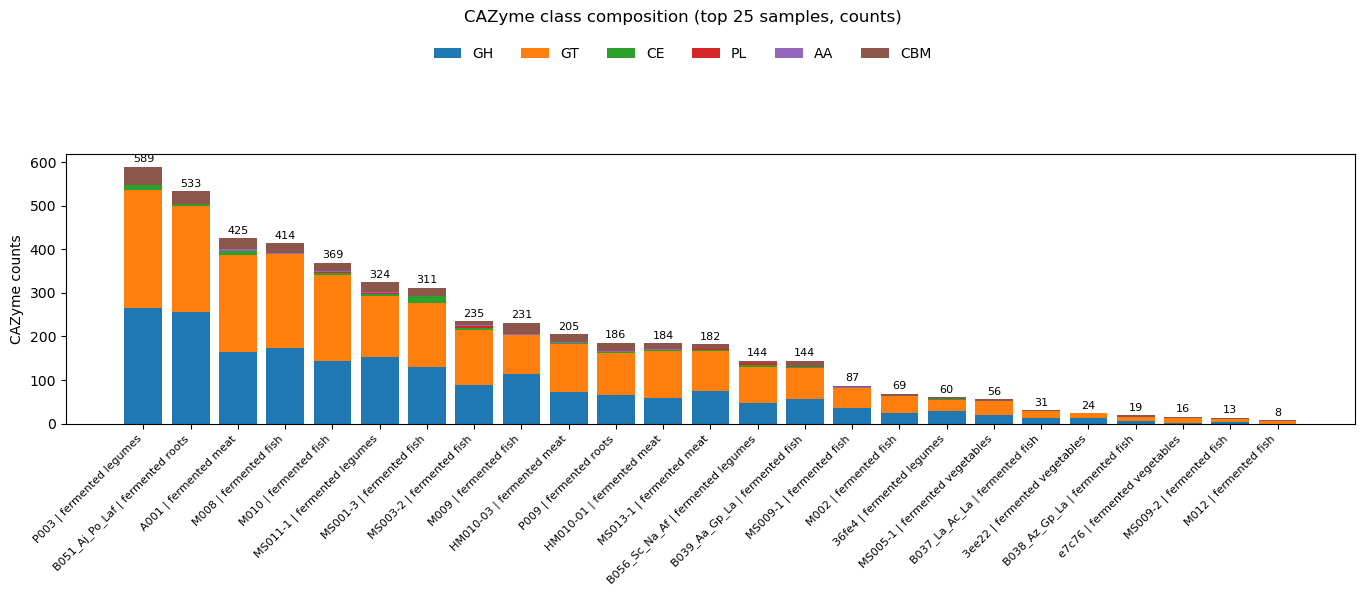

Saved: data/07_Functional_analysis/data/Plots/cazy_class_top25_counts.png


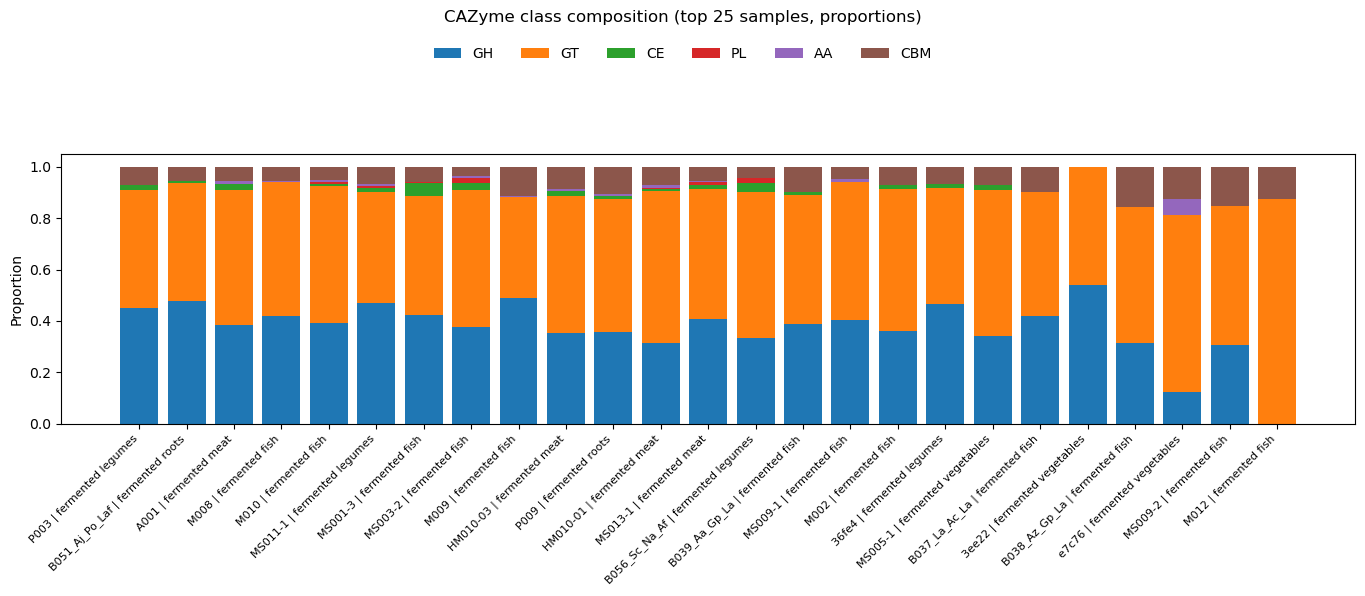

Saved: data/07_Functional_analysis/data/Plots/cazy_class_top25_proportions.png


In [13]:
plot_stacked_bar(
    top_counts,
    title=f"CAZyme class composition (top {TOP_N_SAMPLES} samples, counts)",
    ylabel="CAZyme counts",
    outpath=FIG_DIR / f"cazy_class_top{TOP_N_SAMPLES}_counts.png",
    totals=top_totals,
    proportions=False,
    legend_ncols=7,
)

plot_stacked_bar(
    top_prop,
    title=f"CAZyme class composition (top {TOP_N_SAMPLES} samples, proportions)",
    ylabel="Proportion",
    outpath=FIG_DIR / f"cazy_class_top{TOP_N_SAMPLES}_proportions.png",
    totals=None,
    proportions=True,
    legend_ncols=7,
)


### CAZy class composition (by food category)

This is the same CAZy class summary as the per-sample plot, but samples are grouped by `category`.

- **Counts** are summed within each category (so categories with more samples will usually have larger totals).
- **Proportions** are normalised within each category to compare composition directly.

For reporting, this view is usually easier to read than the per-sample version.


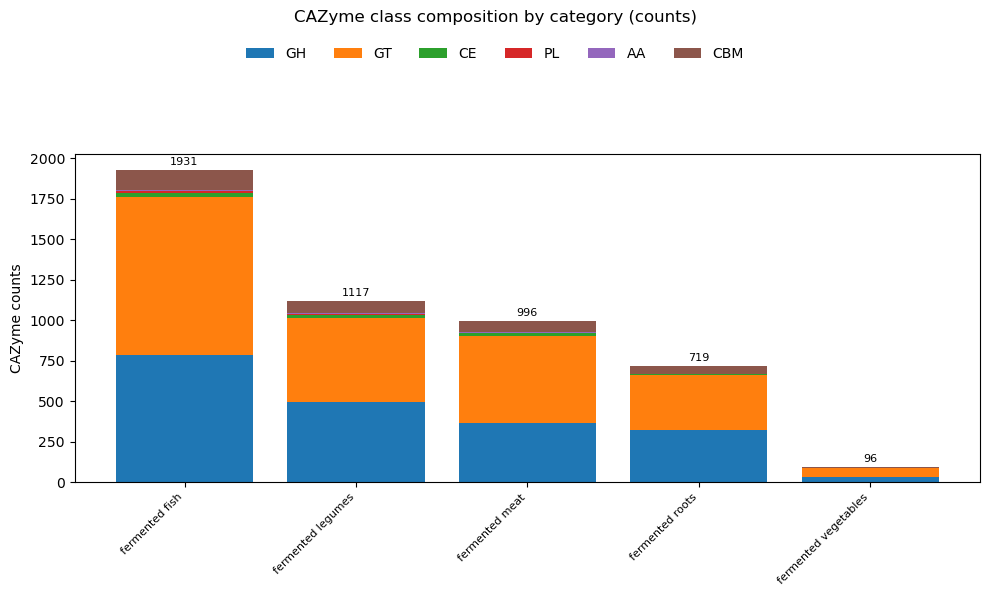

Saved: data/07_Functional_analysis/data/Plots/cazy_class_by_category_counts.png


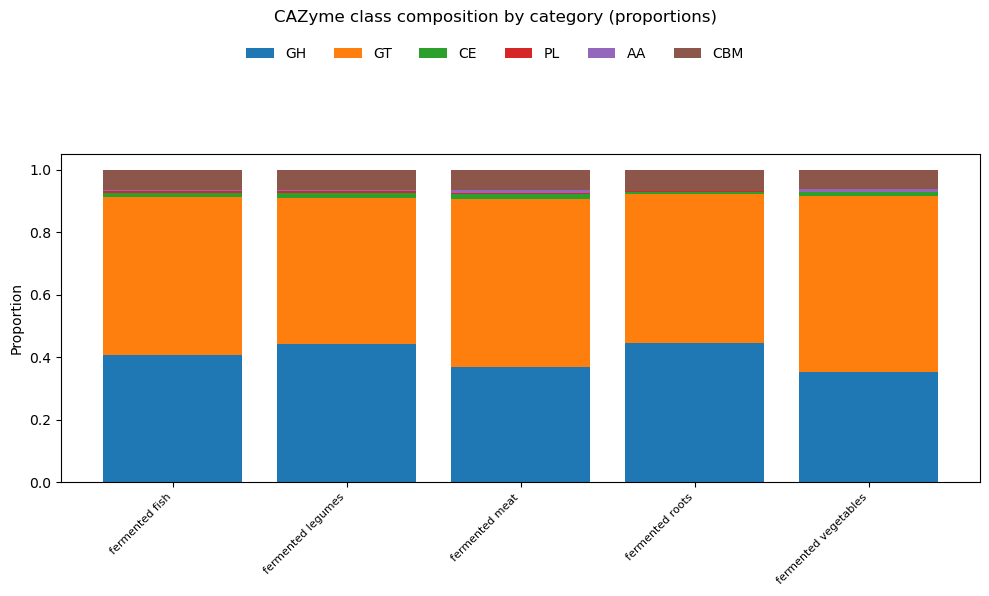

Saved: data/07_Functional_analysis/data/Plots/cazy_class_by_category_proportions.png


In [14]:
cats = pd.Index([x.split("|")[1].strip() for x in top_counts.index])

cat_counts = top_counts.copy()
cat_counts["__cat__"] = cats
cat_counts = cat_counts.groupby("__cat__").sum(numeric_only=True)

cat_totals = cat_counts.sum(axis=1)
cat_prop = cat_counts.div(cat_totals.replace(0, np.nan), axis=0).fillna(0)

plot_stacked_bar(
    cat_counts,
    title="CAZyme class composition by category (counts)",
    ylabel="CAZyme counts",
    outpath=FIG_DIR / "cazy_class_by_category_counts.png",
    totals=cat_totals,
    proportions=False,
    legend_ncols=7,
)

plot_stacked_bar(
    cat_prop,
    title="CAZyme class composition by category (proportions)",
    ylabel="Proportion",
    outpath=FIG_DIR / "cazy_class_by_category_proportions.png",
    totals=None,
    proportions=True,
    legend_ncols=7,
)


### CAZy families

The plots below focus on **CAZy families** (e.g., GH13, GT2). We first select the top families by total abundance, then visualise patterns across samples or categories.

If the feature IDs in the input table do not look like CAZy family names, these plots are skipped (to avoid drawing UUID axes).


In [15]:
def extract_cazy_family(s: str) -> str:
    m = CAZY_FAM_RE.search(str(s))
    return m.group(0).upper() if m else str(s).strip()

mat_family = cazy.copy()
mat_family.index = [extract_cazy_family(i) for i in mat_family.index]
mat_family = mat_family.groupby(level=0).sum()

fam_token_frac = pd.Series(mat_family.index.astype(str)).str.fullmatch(r"(GH|GT|CE|PL|AA|CBM)\d+").mean()
print(f"Family token fraction (after collapsing): {fam_token_frac:.3f}")


Family token fraction (after collapsing): 1.000


#### Heatmap (per-sample)

Heatmap of the top CAZy families across the top samples.

- Values are shown as **log1p(count)** to keep both abundant and rare families visible.
- Samples are ordered by `category` (and then by total CAZyme counts) to make within-category patterns easier to scan.


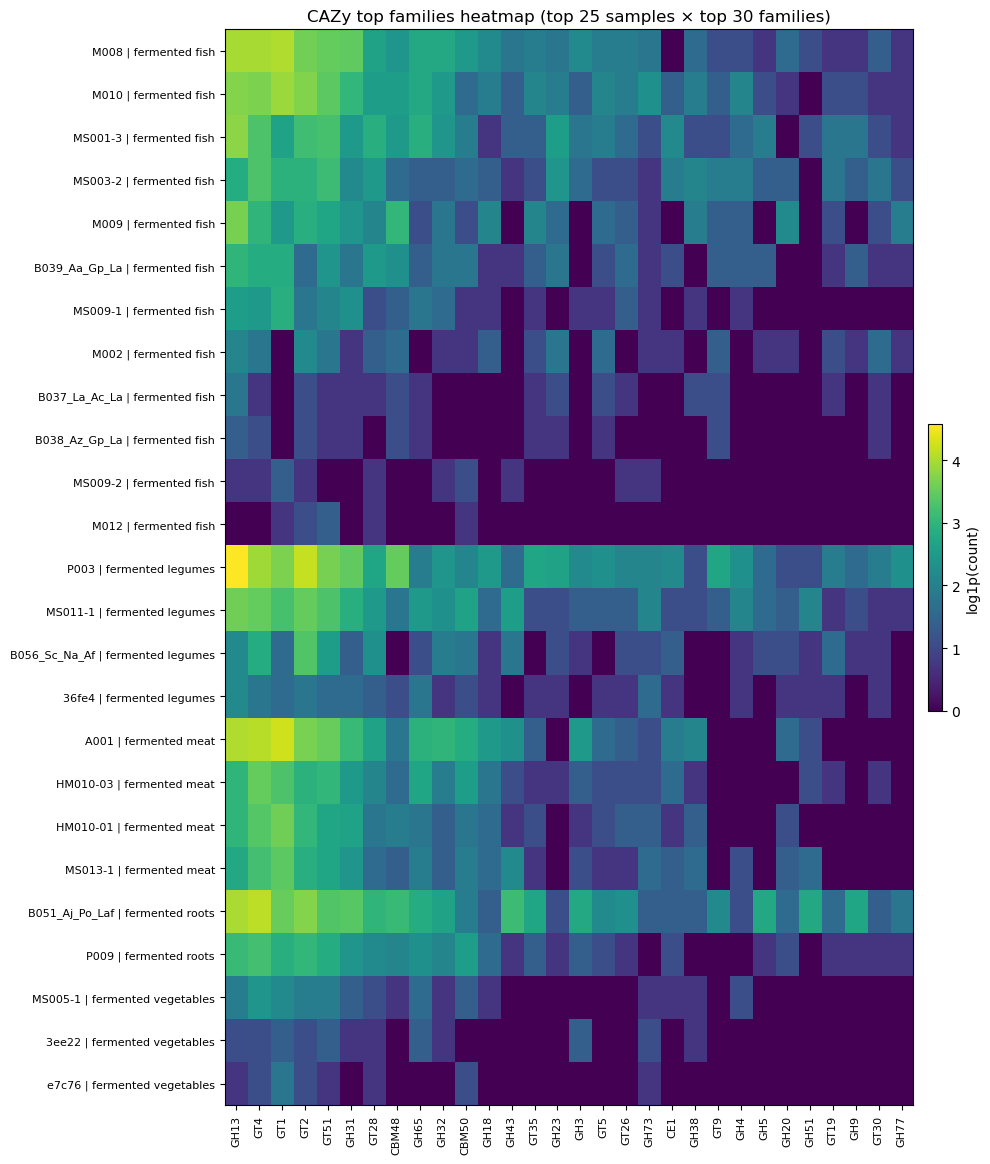

Saved: data/07_Functional_analysis/data/Plots/cazy_top_families_heatmap_samples.png


In [16]:
if fam_token_frac < 0.2:
    print("Skip family plots: feature IDs do not look like CAZy families.")
else:
    fam_totals = mat_family.sum(axis=1).sort_values(ascending=False)
    top_fams = fam_totals.head(TOP_N_FAMILIES).index.tolist()

    top_samps = totals_all.sort_values(ascending=False).head(TOP_N_SAMPLES_FAMS).index.tolist()
    order_df = pd.DataFrame({
        "sample_ID": top_samps,
        "category": [sample2cat.get(s, "NA") for s in top_samps],
        "total": [totals_all.get(s, 0) for s in top_samps],
    }).sort_values(["category", "total"], ascending=[True, False])

    samp_order = order_df["sample_ID"].tolist()
    samp_labels = [f"{s} | {sample2cat.get(s, 'NA')}" for s in samp_order]

    hm = np.log1p(mat_family.loc[top_fams, samp_order].T)

    fig_w = max(10, 0.30 * hm.shape[1])
    fig, ax = plt.subplots(figsize=(fig_w, 0.35 * hm.shape[0] + 3))
    im = ax.imshow(hm.values, aspect="auto")

    ax.set_xticks(np.arange(len(top_fams)))
    ax.set_xticklabels(top_fams, rotation=90, fontsize=8)
    ax.set_yticks(np.arange(len(samp_labels)))
    ax.set_yticklabels(samp_labels, fontsize=8)

    ax.set_title(f"CAZy top families heatmap (top {len(samp_order)} samples × top {len(top_fams)} families)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label("log1p(count)")

    fig.tight_layout()
    out = FIG_DIR / "cazy_top_families_heatmap_samples.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


#### Heatmap (by category)

Category-level version of the heatmap.

Here we take the **mean per sample** within each category and plot **log1p(mean count)**.
This view is helpful if you want a compact summary that is less sensitive to individual outlier samples.


/tmp/ipykernel_1404/1526620622.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return df2.groupby(level=0, axis=1).mean()


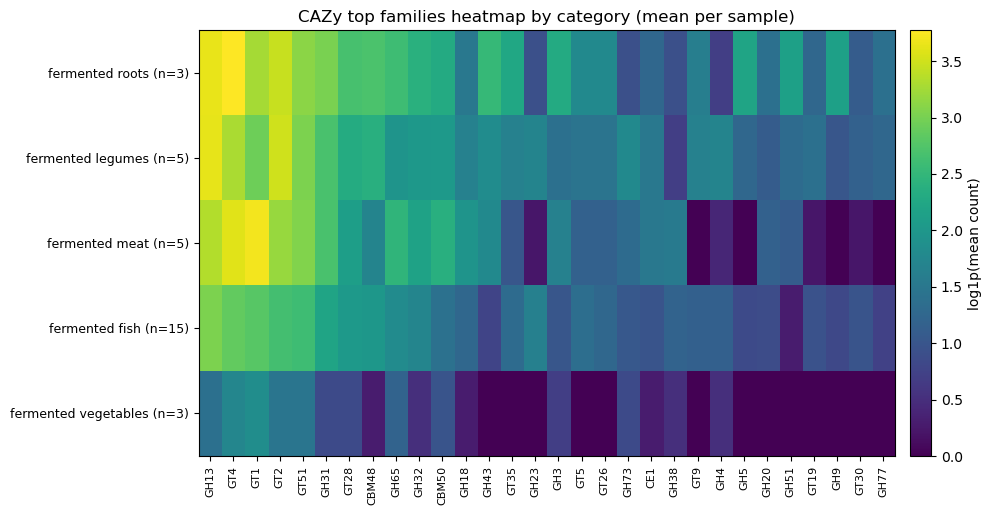

Saved: data/07_Functional_analysis/data/Plots/cazy_top_families_heatmap_by_category.png


In [17]:
if fam_token_frac >= 0.2:
    fam_totals = mat_family.sum(axis=1).sort_values(ascending=False)
    top_fams = fam_totals.head(TOP_N_FAMILIES).index.tolist()

    fam_by_cat = aggregate_columns_to_category(mat_family.loc[top_fams], sample2cat, how="mean")
    cat_order = fam_by_cat.sum(axis=0).sort_values(ascending=False).index.tolist()

    hm_cat = np.log1p(fam_by_cat[cat_order].T)

    n_per_cat = meta.groupby("category").size().to_dict()
    y_labels = [f"{c} (n={n_per_cat.get(c, 0)})" for c in hm_cat.index]

    fig_w = max(10, 0.30 * hm_cat.shape[1])
    fig, ax = plt.subplots(figsize=(fig_w, 0.55 * hm_cat.shape[0] + 2.5))
    im = ax.imshow(hm_cat.values, aspect="auto")

    ax.set_xticks(np.arange(len(top_fams)))
    ax.set_xticklabels(top_fams, rotation=90, fontsize=8)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=9)

    ax.set_title("CAZy top families heatmap by category (mean per sample)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("log1p(mean count)")

    fig.tight_layout()
    out = FIG_DIR / "cazy_top_families_heatmap_by_category.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


#### Dotplot (per-sample)

Dotplot of the same family table (top samples × top families).

This tends to work better than a heatmap when the matrix is sparse, because it makes presence/absence patterns easier to see.
Dot size encodes **log1p(count)**.


In [18]:
if fam_token_frac >= 0.2:
    fam_totals = mat_family.sum(axis=1).sort_values(ascending=False)
    fam_order = fam_totals.head(TOP_N_FAMILIES).index.tolist()

    top_samps = totals_all.sort_values(ascending=False).head(TOP_N_SAMPLES_FAMS).index.tolist()
    order_df = pd.DataFrame({
        "sample_ID": top_samps,
        "category": [sample2cat.get(s, "NA") for s in top_samps],
        "total": [totals_all.get(s, 0) for s in top_samps],
    }).sort_values(["category", "total"], ascending=[True, False])
    samp_order = order_df["sample_ID"].tolist()
    samp_labels = [f"{s} | {sample2cat.get(s, 'NA')}" for s in samp_order]

    sub = mat_family.loc[fam_order, samp_order]
    long = sub.stack().reset_index()
    long.columns = ["family", "sample_ID", "count"]
    long = long[long["count"] > 0].copy()

    long["cls"] = long["family"].map(cazy_class)
    long["size"] = np.log10(long["count"] + 1.0) * 180
    long["sample_label"] = long["sample_ID"].map(lambda s: f"{s} | {sample2cat.get(s, 'NA')}")


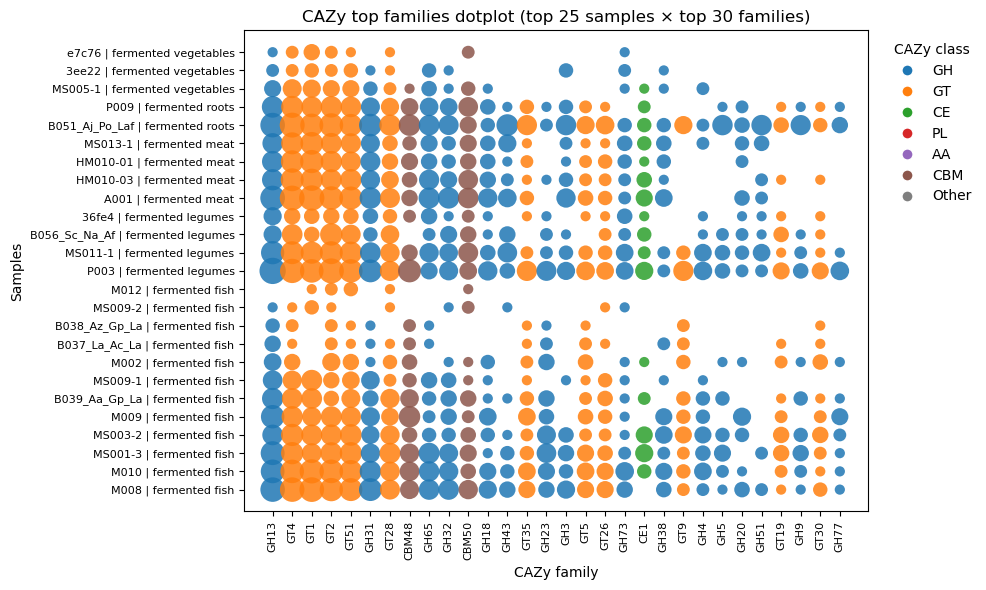

Saved: data/07_Functional_analysis/data/Plots/cazy_top_families_dotplot_samples.png


In [19]:
if fam_token_frac >= 0.2:
    x_pos = {f: i for i, f in enumerate(fam_order)}
    y_pos = {s: i for i, s in enumerate(samp_labels)}

    fig, ax = plt.subplots(figsize=(max(10, 0.32 * len(fam_order)), max(6, 0.24 * len(samp_order))))
    ax.scatter(
        long["family"].map(x_pos),
        long["sample_label"].map(y_pos),
        s=long["size"],
        c=long["cls"].map(CAZY_CLASS_PALETTE),
        alpha=0.85,
        linewidths=0,
    )

    ax.set_xticks(range(len(fam_order)))
    ax.set_xticklabels(fam_order, rotation=90, fontsize=8)
    ax.set_yticks(range(len(samp_order)))
    ax.set_yticklabels(samp_labels, fontsize=8)

    ax.set_title(f"CAZy top families dotplot (top {len(samp_order)} samples × top {len(fam_order)} families)")
    ax.set_xlabel("CAZy family")
    ax.set_ylabel("Samples")

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=CAZY_CLASS_PALETTE[k], markersize=8, label=k)
        for k in ["GH", "GT", "CE", "PL", "AA", "CBM", "Other"]
    ]
    ax.legend(handles=handles, title="CAZy class", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    fig.tight_layout()
    out = FIG_DIR / "cazy_top_families_dotplot_samples.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


#### Dotplot (by category)

Category-level dotplot using the **mean per sample** within each category.

Use this if you want a quick “at-a-glance” summary of which families are more prominent in each food category.


In [20]:
if fam_token_frac >= 0.2:
    fam_totals = mat_family.sum(axis=1).sort_values(ascending=False)
    fam_order = fam_totals.head(TOP_N_FAMILIES).index.tolist()

    fam_by_cat = aggregate_columns_to_category(mat_family.loc[fam_order], sample2cat, how="mean")
    cat_order = fam_by_cat.sum(axis=0).sort_values(ascending=False).index.tolist()

    long_cat = fam_by_cat[cat_order].stack().reset_index()
    long_cat.columns = ["family", "category", "mean_count"]
    long_cat = long_cat[long_cat["mean_count"] > 0].copy()

    long_cat["cls"] = long_cat["family"].map(cazy_class)
    long_cat["size"] = np.log10(long_cat["mean_count"] + 1.0) * 260

    n_per_cat = meta.groupby("category").size().to_dict()
    cat_labels = {c: f"{c} (n={n_per_cat.get(c, 0)})" for c in cat_order}


/tmp/ipykernel_1404/1526620622.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return df2.groupby(level=0, axis=1).mean()


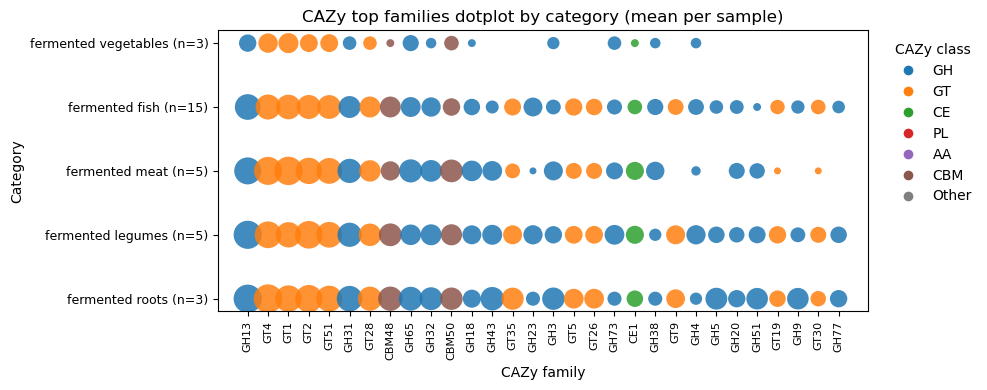

Saved: data/07_Functional_analysis/data/Plots/cazy_top_families_dotplot_by_category.png


In [21]:
if fam_token_frac >= 0.2:
    x_pos = {f: i for i, f in enumerate(fam_order)}
    y_pos = {c: i for i, c in enumerate(cat_order)}

    fig, ax = plt.subplots(figsize=(max(10, 0.32 * len(fam_order)), max(4, 0.55 * len(cat_order))))
    ax.scatter(
        long_cat["family"].map(x_pos),
        long_cat["category"].map(y_pos),
        s=long_cat["size"],
        c=long_cat["cls"].map(CAZY_CLASS_PALETTE),
        alpha=0.85,
        linewidths=0,
    )

    ax.set_xticks(range(len(fam_order)))
    ax.set_xticklabels(fam_order, rotation=90, fontsize=8)
    ax.set_yticks(range(len(cat_order)))
    ax.set_yticklabels([cat_labels[c] for c in cat_order], fontsize=9)

    ax.set_title("CAZy top families dotplot by category (mean per sample)")
    ax.set_xlabel("CAZy family")
    ax.set_ylabel("Category")

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=CAZY_CLASS_PALETTE[k], markersize=8, label=k)
        for k in ["GH", "GT", "CE", "PL", "AA", "CBM", "Other"]
    ]
    ax.legend(handles=handles, title="CAZy class", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    fig.tight_layout()
    out = FIG_DIR / "cazy_top_families_dotplot_by_category.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


### CAZy family PCA

PCA provides a simple way to compare samples by their **overall CAZy family profile**.

We apply log1p to counts and standardise each family before PCA. Points that are closer together have more similar family compositions.
Colour indicates `category`.


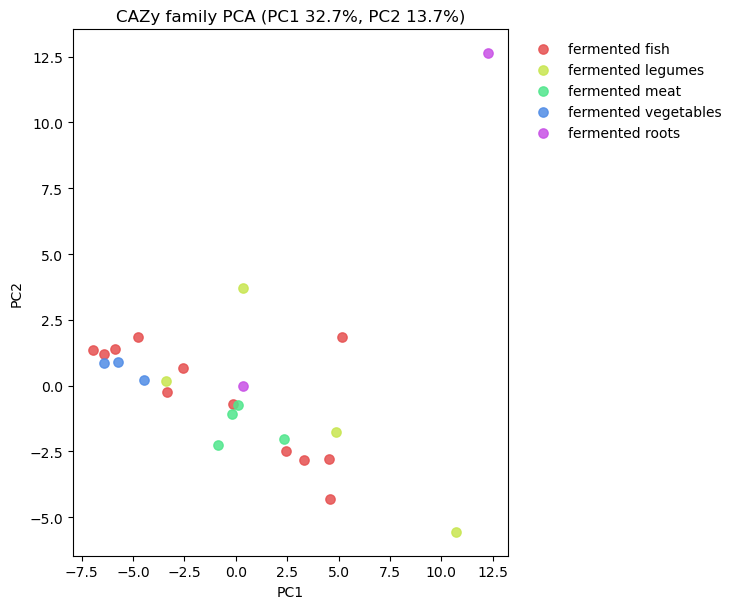

Saved: data/07_Functional_analysis/data/Plots/cazy_family_pca.png


In [22]:
if fam_token_frac < 0.2:
    print("Skip PCA: family IDs do not look like CAZy families.")
else:
    X = mat_family.T.copy()
    X = np.log1p(X)
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)

    scores, evr2 = pca_2d(X.values)
    labels = X.index.tolist()
    groups = [sample2cat.get(s, "NA") for s in labels]

    title = f"CAZy family PCA (PC1 {evr2[0]*100:.1f}%, PC2 {evr2[1]*100:.1f}%)"
    plot_pca(scores, labels=labels, groups=groups, title=title, outpath=FIG_DIR / "cazy_family_pca.png")


## COG

### Load table

In [23]:
# Load COG feature table
cog_export_dir = EXP_DIR / COG_FT_QZA.stem
cog_tsv = _pick_feature_table_tsv(cog_export_dir, COG_FT_QZA.stem)
if cog_tsv is None:
    cog_tsv = cog_export_dir / "feature-table.tsv"

if DO_EXPORT or (not cog_tsv.exists()):
    export_qza_to_tsv(COG_FT_QZA, cog_export_dir, cog_tsv, force=True)

cog = read_biom_tsv(cog_tsv)
cog = map_columns_to_samples(cog, sample2cat=sample2cat, report_name="cog")
print("COG matrix shape (features × samples):", cog.shape)

is_letter_cat = pd.Series(cog.index.astype(str)).str.fullmatch(r"[A-Za-z]").mean() > 0.7
print("COG features look like single-letter categories:", is_letter_cat)


Excluded 2 eukaryotic member IDs from mags_table mapping.
Loaded mags_table mapping: 168 members → 36 reps
Sample columns (cog): 170 → 25 after mapping/aggregation.
COG matrix shape (features × samples): (24, 25)
COG features look like single-letter categories: True


/tmp/ipykernel_1404/1144980675.py:48: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df2 = df2.groupby(level=0, axis=1).sum()


### COG category composition

COG annotations are summarised into single-letter functional categories (e.g., G, K, S).

We plot **proportions** (not raw counts) so that differences in total counts between samples do not dominate the visual comparison.

A small reference table with totals per COG letter (across the plotted top samples) is saved as:
`cog_category_legend.tsv`


In [24]:
if not is_letter_cat:
    print("Skip: COG IDs are not single-letter categories.")
else:
    cog_cat = cog.groupby(level=0).sum()  # letter × sample
    cog_totals = cog_cat.sum(axis=0)

    top_samples = cog_totals.sort_values(ascending=False).head(TOP_N_SAMPLES).index.tolist()
    prop = (cog_cat[top_samples] / cog_totals.loc[top_samples].replace(0, np.nan)).T.fillna(0)

    # Order letters by contribution (within plotted samples)
    cog_order = prop.sum(axis=0).sort_values(ascending=False).index.tolist()
    prop = prop.loc[:, cog_order]
    # Colours: evenly spaced HSV palette for distinct categories.
    # Keep legend labels as COG letter codes (totals are saved to a TSV for reference).
    prop_plot = prop.copy()

    colors = hsv_palette(list(prop_plot.columns))
    # Save totals for each COG category (across the plotted top samples)
    totals_by_letter = cog_cat[top_samples].sum(axis=1).reindex(cog_order).fillna(0).astype(int)
    mean_prop_by_letter = prop.mean(axis=0).reindex(cog_order).fillna(0)

    legend_df = pd.DataFrame({
        "COG_letter": cog_order,
        "total_hits_top_samples": totals_by_letter.values,
        "mean_proportion_top_samples": mean_prop_by_letter.values,
    })
    legend_path = FIG_DIR / "cog_category_legend.tsv"
    legend_df.to_csv(legend_path, sep="\t", index=False)
    print("Saved:", legend_path)

    # Label rows for plotting
    prop_plot.index = [f"{sid} | {sample2cat.get(sid, 'NA')}" for sid in prop_plot.index]


Saved: data/07_Functional_analysis/data/Plots/cog_category_legend.tsv


#### Per-sample (top samples)

Each bar is a single sample (top N by total COG hits). This keeps sample-to-sample variability visible.


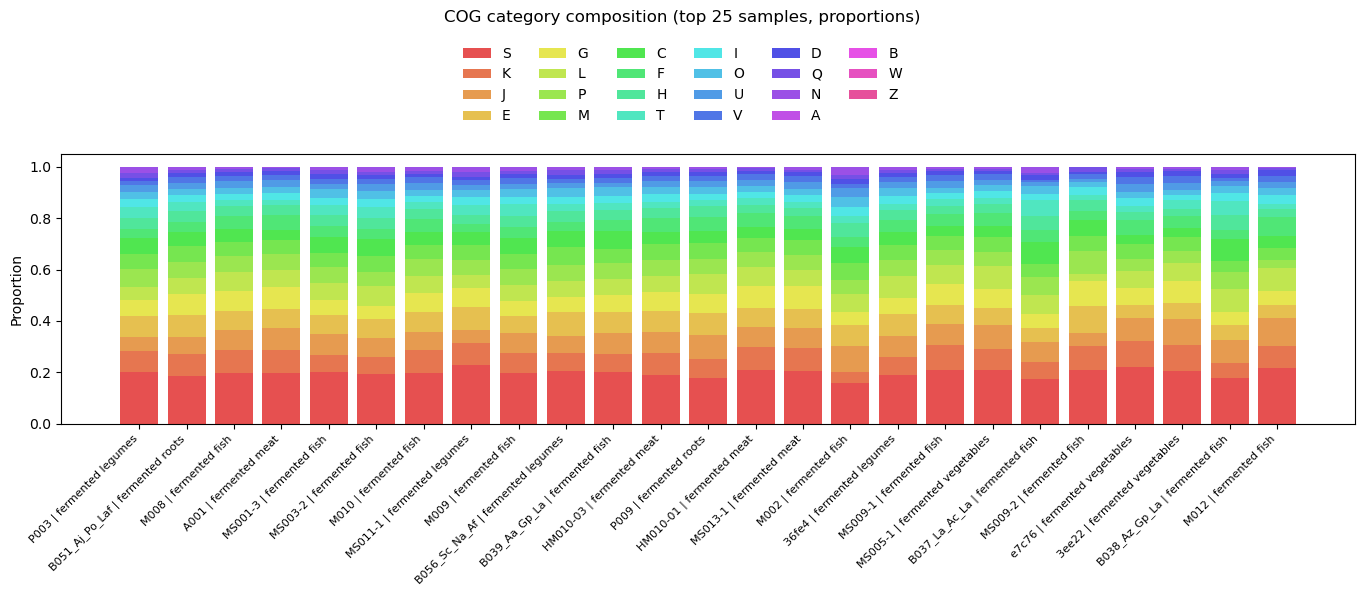

Saved: data/07_Functional_analysis/data/Plots/cog_category_top25_proportions.png


In [25]:
if is_letter_cat:
    plot_stacked_bar(
        prop_plot,
        title=f"COG category composition (top {TOP_N_SAMPLES} samples, proportions)",
        ylabel="Proportion",
        outpath=FIG_DIR / f"cog_category_top{TOP_N_SAMPLES}_proportions.png",
        totals=None,
        proportions=True,
        colors=colors,
        legend_ncols=6,
    )


#### By category (mean proportions)

Here we average proportions across samples within each `category`. The x-axis label includes `n` (number of samples).


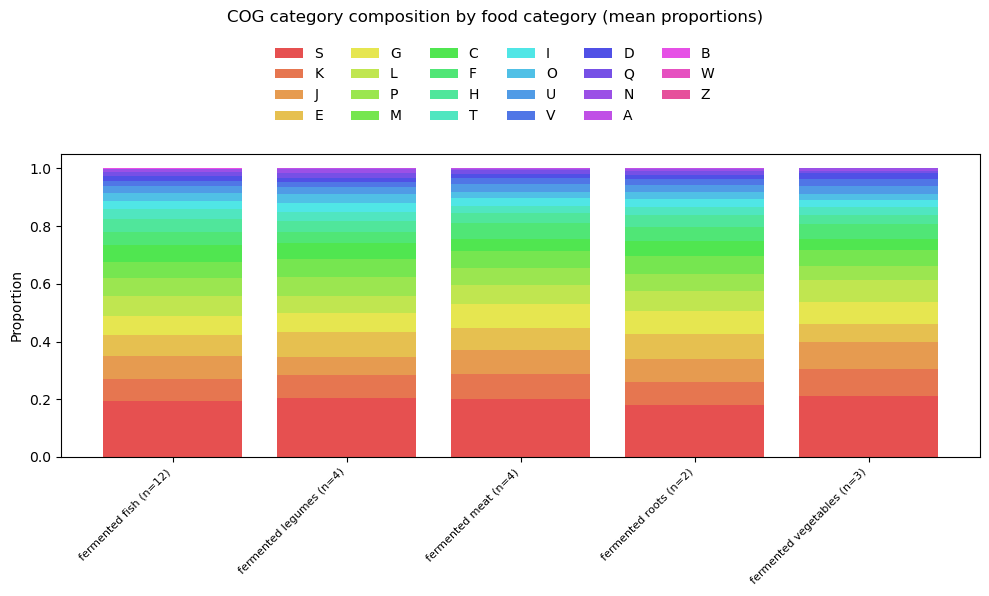

Saved: data/07_Functional_analysis/data/Plots/cog_category_by_category_proportions.png


In [26]:
if is_letter_cat:
    # By category: mean proportion across samples in each category
    cats = prop_plot.index.to_series().str.split("|").str[1].str.strip()

    prop_by_cat = prop_plot.copy()
    prop_by_cat["__cat__"] = cats.values
    prop_by_cat = prop_by_cat.groupby("__cat__").mean(numeric_only=True)

    n_per_cat = cats.value_counts()
    prop_by_cat.index = [f"{c} (n={int(n_per_cat.get(c, 0))})" for c in prop_by_cat.index]

    plot_stacked_bar(
        prop_by_cat,
        title="COG category composition by food category (mean proportions)",
        ylabel="Proportion",
        outpath=FIG_DIR / "cog_category_by_category_proportions.png",
        totals=None,
        proportions=True,
        colors=colors,
        legend_ncols=6,
    )


### COG PCA

PCA on the sample-by-COG-category matrix (log1p-transformed and standardised).

This is a quick check for whether samples cluster by food category in broad functional space, and to flag any strong outliers.


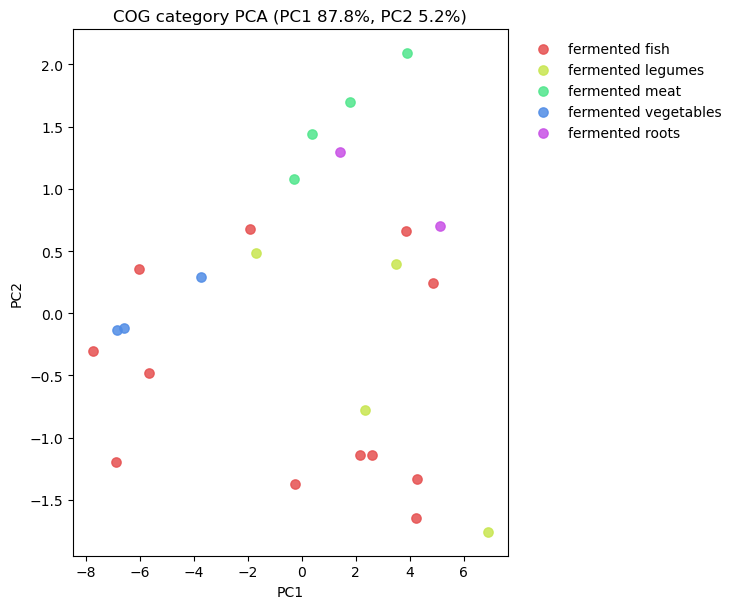

Saved: data/07_Functional_analysis/data/Plots/cog_category_pca.png


In [27]:
if is_letter_cat:
    cog_cat = cog.groupby(level=0).sum()
    X = cog_cat.T.copy()
    X = np.log1p(X)
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)

    scores, evr2 = pca_2d(X.values)
    labels = X.index.tolist()
    groups = [sample2cat.get(s, "NA") for s in labels]

    title = f"COG category PCA (PC1 {evr2[0]*100:.1f}%, PC2 {evr2[1]*100:.1f}%)"
    plot_pca(scores, labels=labels, groups=groups, title=title, outpath=FIG_DIR / "cog_category_pca.png")


## AMR

### Load table

In [28]:
# Load AMR feature table
amr_export_dir = EXP_DIR / AMR_FT_QZA.stem
amr_tsv = _pick_feature_table_tsv(amr_export_dir, AMR_FT_QZA.stem)
if amr_tsv is None:
    amr_tsv = amr_export_dir / "feature-table.tsv"

if DO_EXPORT or (not amr_tsv.exists()):
    export_qza_to_tsv(AMR_FT_QZA, amr_export_dir, amr_tsv, force=True)

amr = read_biom_tsv(amr_tsv)
amr = map_columns_to_samples(amr, sample2cat=sample2cat, report_name="amr")
print("AMR matrix shape (features × samples):", amr.shape)

amr_total = amr.sum(axis=0).sort_values(ascending=False)
amr_df = pd.DataFrame({
    "sample_ID": amr_total.index,
    "category": [sample2cat.get(s, "NA") for s in amr_total.index],
    "amr_total": amr_total.values,
})


Excluded 2 eukaryotic member IDs from mags_table mapping.
Loaded mags_table mapping: 168 members → 36 reps
Sample columns (amr): 66 → 22 after mapping/aggregation.
AMR matrix shape (features × samples): (43, 22)


/tmp/ipykernel_1404/1144980675.py:48: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df2 = df2.groupby(level=0, axis=1).sum()


### AMR burden (per-sample)

We summarise AMR as the **total number of AMR hits per sample** (sum across AMR features) and plot the top samples.

This is mainly a screening plot to identify samples with unusually high AMR signal.


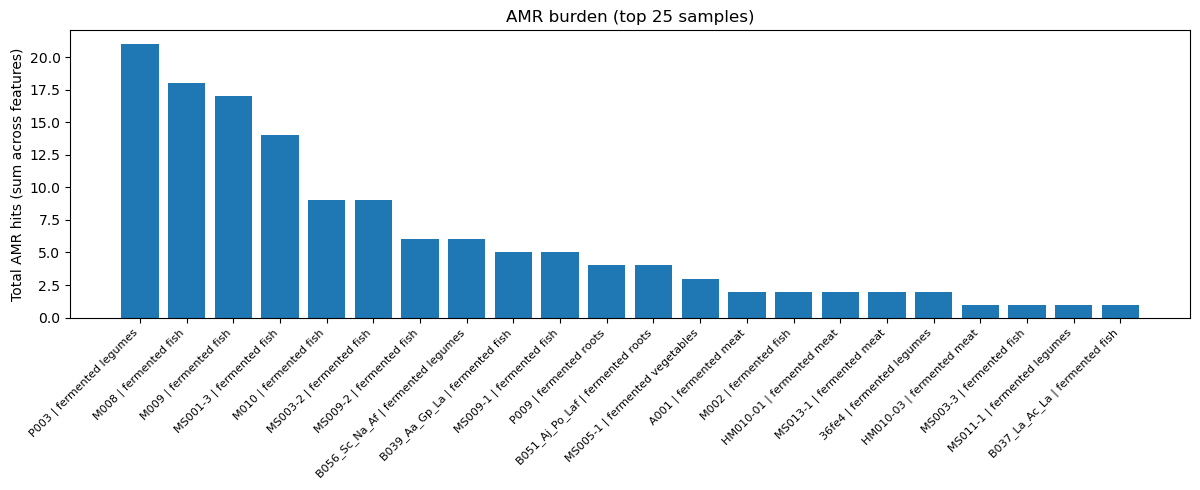

Saved: data/07_Functional_analysis/data/Plots/amr_top25_samples.png


In [29]:
top = amr_df.head(TOP_N_SAMPLES).copy()
x = np.arange(len(top))
labels = [f"{s} | {c}" for s, c in zip(top["sample_ID"], top["category"])]

fig, ax = plt.subplots(figsize=(max(12, 0.55 * len(top)), 5))
ax.bar(x, top["amr_total"].values)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Total AMR hits (sum across features)")
ax.set_title(f"AMR burden (top {TOP_N_SAMPLES} samples)")
fig.tight_layout()

out = FIG_DIR / f"amr_top{TOP_N_SAMPLES}_samples.png"
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out)


### AMR burden (by category)

Two complementary summaries are shown:

- **Summed totals** by category (overall AMR signal per category).
- **Distribution per sample** within each category (box + points).

A log-scale version of the boxplot is included to make low-burden categories easier to compare.


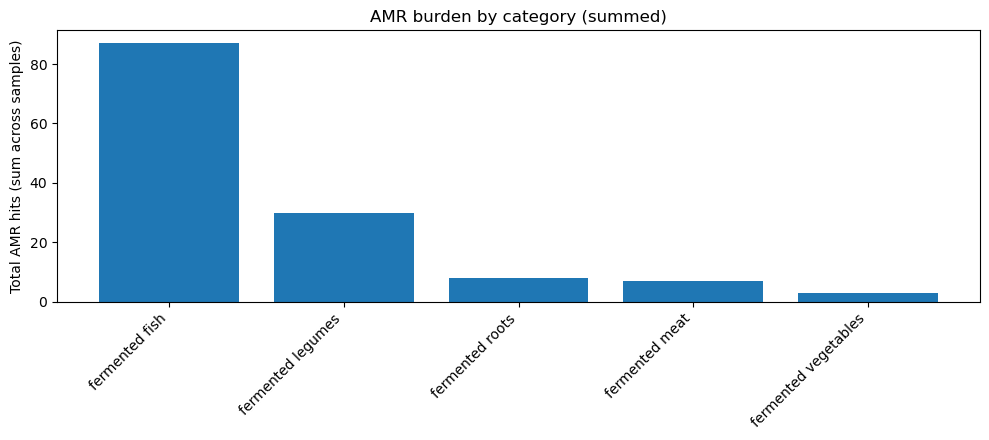

Saved: data/07_Functional_analysis/data/Plots/amr_by_category_summed.png


In [30]:
by_cat = amr_df.groupby("category")["amr_total"].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.bar(np.arange(len(by_cat)), by_cat.values)
ax.set_xticks(np.arange(len(by_cat)))
ax.set_xticklabels(by_cat.index, rotation=45, ha="right")
ax.set_ylabel("Total AMR hits (sum across samples)")
ax.set_title("AMR burden by category (summed)")
fig.tight_layout()

out = FIG_DIR / "amr_by_category_summed.png"
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out)


In [31]:
cats = [c for c in amr_df["category"].unique() if c != "NA"]
cats = sorted(cats)
vals_by_cat = [amr_df.loc[amr_df["category"] == c, "amr_total"].values for c in cats]


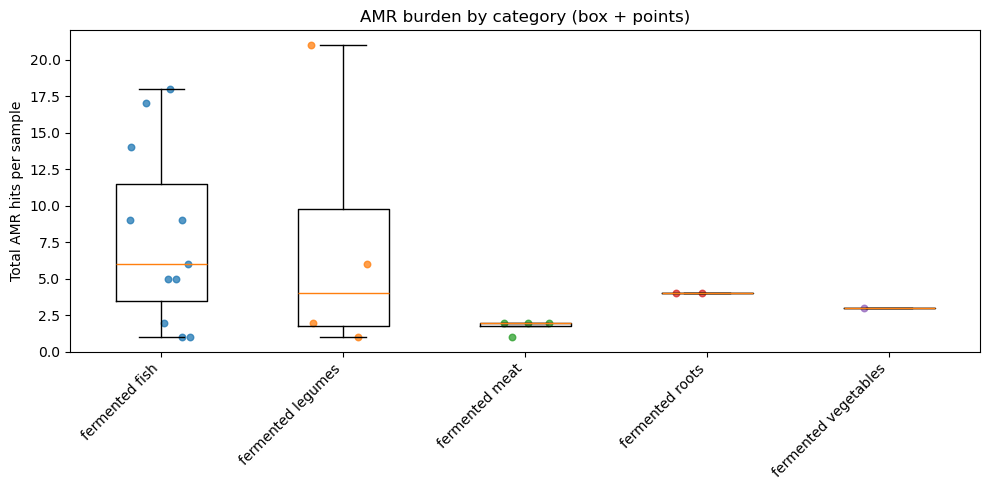

Saved: data/07_Functional_analysis/data/Plots/amr_by_category_boxpoints.png


In [32]:
# Box + points (linear)
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(vals_by_cat, labels=cats, showfliers=False)

rng = np.random.default_rng(RANDOM_SEED)
for i, vals in enumerate(vals_by_cat, start=1):
    jitter = rng.uniform(-0.18, 0.18, size=len(vals))
    ax.scatter(np.full(len(vals), i) + jitter, vals, alpha=0.75, s=22)

ax.set_ylabel("Total AMR hits per sample")
ax.set_title("AMR burden by category (box + points)")
ax.tick_params(axis="x", rotation=45)
for t in ax.get_xticklabels():
    t.set_ha("right")
fig.tight_layout()

out = FIG_DIR / "amr_by_category_boxpoints.png"
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out)


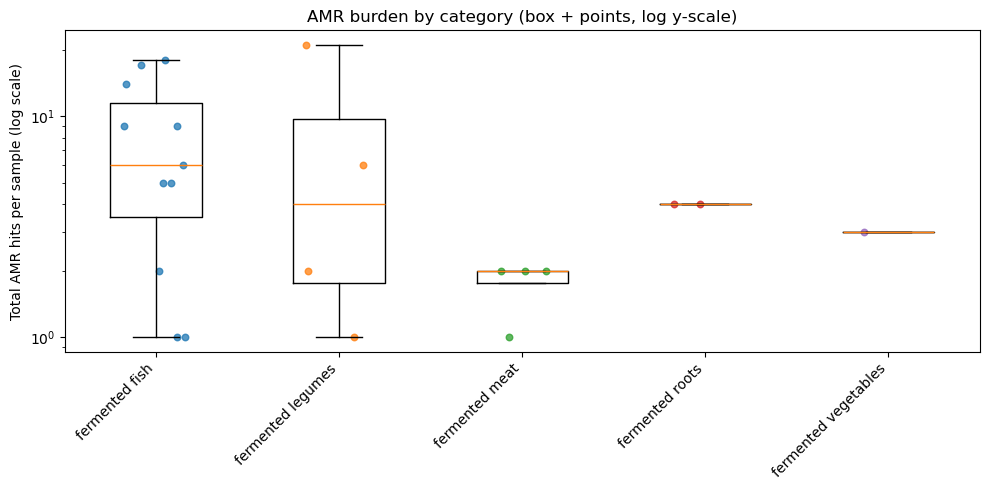

Saved: data/07_Functional_analysis/data/Plots/amr_by_category_boxpoints_log.png


In [33]:
# Box + points (log y-scale)
vals_min = np.min([np.min(v) for v in vals_by_cat if len(v) > 0])
use_log = vals_min > 0

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(vals_by_cat, labels=cats, showfliers=False)

rng = np.random.default_rng(RANDOM_SEED)
for i, vals in enumerate(vals_by_cat, start=1):
    jitter = rng.uniform(-0.18, 0.18, size=len(vals))
    ax.scatter(np.full(len(vals), i) + jitter, vals, alpha=0.75, s=22)

if use_log:
    ax.set_yscale("log")
    ylab = "Total AMR hits per sample (log scale)"
else:
    ax.set_yscale("symlog", linthresh=1)
    ylab = "Total AMR hits per sample (symlog)"

ax.set_ylabel(ylab)
ax.set_title("AMR burden by category (box + points, log y-scale)")
ax.tick_params(axis="x", rotation=45)
for t in ax.get_xticklabels():
    t.set_ha("right")
fig.tight_layout()

out = FIG_DIR / "amr_by_category_boxpoints_log.png"
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out)
